## RAW MODEL

In [187]:
import pandas as pd
from datetime import datetime

modeling_data = pd.read_csv('./grammy_dashboard/data/modeling_data.csv')

test_data = pd.read_csv('./grammy_dashboard/data/testing_data.csv').rename(columns = {'is_explicit': 'explicit'})

for col in ['charted_q1', 'charted_q2', 'charted_q3', 'charted_q4', 'explicit']:
    modeling_data[col] = modeling_data[col].map({True: 1, False: 0})
    test_data[col] = test_data[col].map({True: 1, False: 0})

modeling_data['song+artist'] = modeling_data.song + modeling_data.artist

In [177]:
print(modeling_data.columns)
print(test_data.columns)

Index(['artist', 'song', 'won_grammy', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'duration_sec', 'weeks_on_chart', 'peak_position', 'started_charting',
       'charted_q1', 'charted_q2', 'charted_q3', 'charted_q4', 'song+artist'],
      dtype='object')
Index(['spotify_id', 'song', 'artist', 'explicit', 'release_data',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'duration_sec', 'weeks_on_chart', 'peak_position',
       'started_charting', 'charted_q1', 'charted_q2', 'charted_q3',
       'charted_q4'],
      dtype='object')


In [199]:
X = modeling_data.drop(columns = ['won_grammy', 'artist', 'song', 'started_charting', 'song+artist'])
y = modeling_data.won_grammy.map({'Yes': 1, 'No': 0})

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    X[col] = X[col].astype('category')
    test_data[col] = test_data[col].astype('category')

X_test = test_data.drop(columns = ['artist', 'song', 'started_charting', 'spotify_id'])
X_test = X_test[pd.to_datetime(X_test['release_data']) > datetime(2023, 9, 1)].drop(columns = 'release_data')
indexer = test_data[pd.to_datetime(test_data['release_data']) > datetime(2023, 9, 1)][['song', 'artist']]

In [ ]:
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    base = XGBClassifier(**params, scale_pos_weight = 5149/61, enable_categorical = True, random_state = 40)


    cv_scores = cross_val_score(base, X, y, cv = 5, scoring = 'precision')

    return cv_scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 75)

[I 2025-06-02 10:49:28,787] A new study created in memory with name: no-name-602889c8-56de-44e2-94dc-ce89a1d35b15
[I 2025-06-02 10:49:30,427] Trial 0 finished with value: 0.18055555555555552 and parameters: {'n_estimators': 269, 'learning_rate': 0.34144103909489865, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.09619893882757602, 'subsample': 0.5552877308007853, 'colsample_bytree': 0.6650650106991892, 'reg_alpha': 9.32202236567319, 'reg_lambda': 1.381278148672097}. Best is trial 0 with value: 0.18055555555555552.
[I 2025-06-02 10:49:31,954] Trial 1 finished with value: 0.10357142857142856 and parameters: {'n_estimators': 486, 'learning_rate': 0.3667007096897885, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.09886317157558684, 'subsample': 0.9910097024012612, 'colsample_bytree': 0.8597503767921187, 'reg_alpha': 2.452908450797832, 'reg_lambda': 0.22978674639269947}. Best is trial 0 with value: 0.18055555555555552.
[I 2025-06-02 10:49:34,918] Trial 2 finished with value: 0.126666

In [200]:
# Generate Prediction

model = XGBClassifier(**study.best_params, scale_pos_weight = 5149/61, enable_categorical = True, random_state = 40).fit(X, y)

threshold = 0.8
train_prediction = model.predict_proba(X)
prediction = model.predict_proba(X_test)

print('--------- Sample Test Prediction ---------')

csv_pred = pd.DataFrame({'Grammy_Prob': prediction[:,1]}, index = indexer)
display(csv_pred.sort_values(ascending = False, by = 'Grammy_Prob').head(15))

# Metrics

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, f1_score

print('------------------ Metrics ------------------')
print('best parameters:', study.best_params)

def metrics(prediction, actual, threshold):

    bi_prediction = (prediction >= threshold).astype(int)[:,1]
    print('Recall:', recall_score(actual, bi_prediction))
    print('ROC/AUC:', roc_auc_score(actual, bi_prediction))
    print('accuracy:', accuracy_score(actual, bi_prediction))
    print('F1:', f1_score(actual, bi_prediction))

    confusion_mat = confusion_matrix(actual, bi_prediction)
    labels = ['Actual Negative', 'Actual Positive']
    formatted_confusion_mat = pd.DataFrame(confusion_mat, index=labels, columns=[f'Predicted {label}' for label in labels])
    print('\n-------------- Confusion Matrix --------------')
    display(formatted_confusion_mat)

metrics(train_prediction, y, threshold)

--------- Sample Test Prediction ---------


,Grammy_Prob
"(Lose Control, Teddy Swims)",0.968586
"(Beautiful Things, Benson Boone)",0.724816
"(Too Sweet, Hozier)",0.241355
"(A Bar Song (Tipsy), Shaboozey)",0.128170
"(Lovin On Me, Jack Harlow)",0.115840
"(we can't be friends (wait for your love), Ariana Grande)",0.076414
"(Fortnight (feat. Post Malone), Taylor Swift, Post Malone)",0.055004
"(TEXAS HOLD 'EM, Beyoncé)",0.032967
"(Good Luck, Babe!, Chappell Roan)",0.028789
"(Slime You Out (feat. SZA), Drake, SZA)",0.024715


------------------ Metrics ------------------
best parameters: {'n_estimators': 221, 'learning_rate': 0.4843600747202524, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.06508438691372113, 'subsample': 0.7696178022307156, 'colsample_bytree': 0.6793017150255182, 'reg_alpha': 0.356038867045795, 'reg_lambda': 9.228580332938629}
Recall: 1.0
ROC/AUC: 1.0
accuracy: 1.0
F1: 1.0

-------------- Confusion Matrix --------------


,Predicted Actual Negative,Predicted Actual Positive
Actual Negative,7547,0
Actual Positive,0,61


<Axes: xlabel='Importance', ylabel='Feature'>

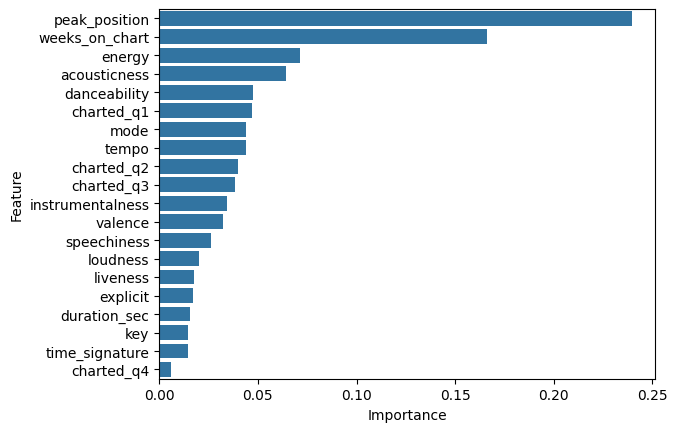

In [ ]:
#Feature Importance

import seaborn as sns

importances  = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': pd.DataFrame(X).columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(feature_importance_df, x = 'Importance', y = 'Feature')

In [201]:
train_600 = pd.DataFrame({'Grammy_Prob': train_prediction[:,1]}, index = modeling_data['song+artist'])
train_600 = train_600.sort_values(ascending = False, by = 'Grammy_Prob')[0:600]
train_600 = pd.merge(train_600, modeling_data, how = 'left', on = 'song+artist')

X_600 = train_600.drop(columns = ['won_grammy', 'artist', 'song', 'started_charting', 'song+artist'])
y_600 = train_600.won_grammy.map({'Yes': 1, 'No': 0})

categorical_cols = X_600.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    X_600[col] = X_600[col].astype('category')

y_600.value_counts()

won_grammy
0    539
1     61
Name: count, dtype: int64

In [203]:
def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    base = XGBClassifier(**params, scale_pos_weight = 5149/61, enable_categorical = True, random_state = 40)


    cv_scores = cross_val_score(base, X_600, y_600, cv = 5, scoring = 'precision')

    return cv_scores.mean()

study_600 = optuna.create_study(direction='maximize')
study_600.optimize(objective, n_trials = 75)

[I 2025-06-02 11:11:00,277] A new study created in memory with name: no-name-992222d0-f8c0-4299-ac0e-945f54349042
[I 2025-06-02 11:11:01,555] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 336, 'learning_rate': 0.010643573611783379, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.05290825287055348, 'subsample': 0.6956967734680224, 'colsample_bytree': 0.9697226749950638, 'reg_alpha': 3.0579973390708117, 'reg_lambda': 6.801970841493738}. Best is trial 0 with value: 1.0.
[I 2025-06-02 11:11:02,624] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 433, 'learning_rate': 0.22005359745804523, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.08509297519713613, 'subsample': 0.6877880376072527, 'colsample_bytree': 0.7770316035203675, 'reg_alpha': 7.1085195272996895, 'reg_lambda': 8.640331829233737}. Best is trial 0 with value: 1.0.
[I 2025-06-02 11:11:03,507] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 340, 'learning_rate': 0.17794731